In [1]:
# import data
import sys
from pathlib import Path
import subprocess
import os
import gc
from glob import glob

import numpy as np
import pandas as pd
import polars as pl
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

ROOT = '/Users/bingzhi/git/finrisk/cririsk'

In [2]:
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

In [3]:
class Pipeline:

    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))
        return df

    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))  #!!?
                df = df.with_columns(pl.col(col).dt.total_days()) # t - t-1
        df = df.drop("date_decision", "MONTH")
        return df

    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()
                if isnull > 0.7:
                    df = df.drop(col)
        
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()
                if (freq == 1) | (freq > 200):
                    df = df.drop(col)
        
        return df

In [4]:
class Aggregator:
    #Please add or subtract features yourself, be aware that too many features will take up too much space.
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return expr_max +expr_last+expr_mean
    
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return  expr_max +expr_last+expr_mean
    
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        #expr_count = [pl.count(col).alias(f"count_{col}") for col in cols]
        return  expr_max +expr_last#+expr_count
    
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return  expr_max +expr_last
    
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols] 
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return  expr_max +expr_last
    
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

In [5]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    if depth in [1,2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df)) 
    return df

def read_files(regex_path, depth=None):
    chunks = []
    
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        chunks.append(df)
    
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    return df

In [6]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
    df_base = df_base.pipe(Pipeline.handle_dates)
    return df_base

In [7]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    return df_data, cat_cols

In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [9]:
ROOT            = Path('/Users/bingzhi/git/finrisk/cririsk')

TRAIN_DIR       = ROOT / "dataset" / "train"
TEST_DIR        = ROOT / "dataset" / "test"

In [10]:
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
        read_file(TRAIN_DIR / "train_applprev_2.parquet", 2),
        read_file(TRAIN_DIR / "train_person_2.parquet", 2)
    ]
}

In [11]:
df_train = feature_eng(**data_store)
print("train data shape:\t", df_train.shape)
del data_store
df_train = df_train.pipe(Pipeline.filter_cols)
gc.collect()

train data shape:	 (1526659, 861)


0

In [12]:
cnt_encoding_cols = df_train.select(pl.selectors.by_dtype([pl.String, pl.Boolean, pl.Categorical])).columns

mappings = {}
for col in cnt_encoding_cols:
    mappings[col] = df_train.group_by(col).len()

df_train_lazy = df_train.select(mappings.keys()).lazy()
# df_train_lazy = pl.LazyFrame(df_train.select('case_id'))

for col, mapping in mappings.items():
    remapping = {category: count for category, count in mapping.rows()}
    remapping[None] = -2
    expr = pl.col(col).replace(
                remapping,
                default=-1,
            )
    df_train_lazy = df_train_lazy.with_columns(expr.alias(col + '_cnt'))
    del col, mapping, remapping
    gc.collect()

del mappings
transformed_train = df_train_lazy.collect()

df_train = pl.concat([df_train, transformed_train.select("^*cnt$")], how='horizontal')
del transformed_train, cnt_encoding_cols

gc.collect()


0

In [13]:

df_train, cat_cols = to_pandas(df_train)
df_train = reduce_mem_usage(df_train)
print("train data shape:\t", df_train.shape)
nums=df_train.select_dtypes(exclude='category').columns
from itertools import combinations, permutations
#df_train=df_train[nums]
nans_df = df_train[nums].isna()
nans_groups={}
for col in nums:
    cur_group = nans_df[col].sum()
    try:
        nans_groups[cur_group].append(col)
    except:
        nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()

def reduce_group(grps):
    use = []
    for g in grps:
        mx = 0; vx = g[0]
        for gg in g:
            n = df_train[gg].nunique()
            if n>mx:
                mx = n
                vx = gg
            #print(str(gg)+'-'+str(n),', ',end='')
        use.append(vx)
        #print()
    print('Use these',use)
    return use

def group_columns_by_correlation(matrix, threshold=0.8):
    # 计算列之间的相关性
    correlation_matrix = matrix.corr()

    # 分组列
    groups = []
    remaining_cols = list(matrix.columns)
    while remaining_cols:
        col = remaining_cols.pop(0)
        group = [col]
        correlated_cols = [col]
        for c in remaining_cols:
            if correlation_matrix.loc[col, c] >= threshold:
                group.append(c)
                correlated_cols.append(c)
        groups.append(group)
        remaining_cols = [c for c in remaining_cols if c not in correlated_cols]
    
    return groups

uses=[]
for k,v in nans_groups.items():
    if len(v)>1:
            Vs = nans_groups[k]
            #cross_features=list(combinations(Vs, 2))
            #make_corr(Vs)
            grps= group_columns_by_correlation(df_train[Vs], threshold=0.8)
            use=reduce_group(grps)
            uses=uses+use
            #make_corr(use)
    else:
        uses=uses+v
    print('####### NAN count =',k)
print(uses)
print(len(uses))
uses=uses+list(df_train.select_dtypes(include='category').columns)
print(len(uses))
df_train=df_train[uses]
df_train.drop(['requesttype_4525192L_cnt','max_empl_employedtotal_800L_cnt', 'max_empl_industry_691L_cnt'], axis=1, inplace=True)

Memory usage of dataframe is 5650.57 MB
Memory usage after optimization is: 2894.48 MB
Decreased by 48.8%
train data shape:	 (1526659, 586)
Use these ['case_id', 'WEEK_NUM', 'target', 'month_decision', 'weekday_decision', 'credamount_770A', 'applicationcnt_361L', 'applications30d_658L', 'applicationscnt_1086L', 'applicationscnt_464L', 'applicationscnt_867L', 'clientscnt_1022L', 'clientscnt_100L', 'clientscnt_1071L', 'clientscnt_1130L', 'clientscnt_157L', 'clientscnt_257L', 'clientscnt_304L', 'clientscnt_360L', 'clientscnt_493L', 'clientscnt_533L', 'clientscnt_887L', 'clientscnt_946L', 'deferredmnthsnum_166L', 'disbursedcredamount_1113A', 'downpmt_116A', 'homephncnt_628L', 'isbidproduct_1095L', 'mobilephncnt_593L', 'numactivecreds_622L', 'numactivecredschannel_414L', 'numactiverelcontr_750L', 'numcontrs3months_479L', 'numnotactivated_1143L', 'numpmtchanneldd_318L', 'numrejects9m_859L', 'sellerplacecnt_915L', 'max_mainoccupationinc_384A', 'max_birth_259D', 'max_relationshiptoclient_415T_

In [14]:
nums = df_train.select_dtypes(exclude='category').columns
df_train_bin = df_train[nums]
#df_train_bin = df_train_bin.drop('case_id', axis=1)


In [15]:
df_train_bin.head()

,case_id,WEEK_NUM,target,month_decision,weekday_decision,credamount_770A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,...,max_pmts_year_507T,last_pmts_month_158T,last_pmts_year_1139T,last_pmts_month_706T,last_pmts_year_507T,max_num_group1_13,max_num_group2_13,last_num_group2_13,max_num_group1_15,max_num_group2_15
0,0,0,0,1,4,30000.000000,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0,1,4,19999.800781,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0,1,5,78000.000000,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,0,1,4,40000.000000,0.0,1.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,1,1,5,44000.000000,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df_train

,case_id,WEEK_NUM,target,month_decision,weekday_decision,credamount_770A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,...,max_cacccardblochreas_147M,last_cacccardblochreas_147M,max_conts_type_509L,last_conts_type_509L,max_conts_role_79M,max_empls_economicalst_849M,max_empls_employer_name_740M,last_conts_role_79M,last_empls_economicalst_849M,last_empls_employer_name_740M
0,0,0,0,1,4,30000.000000,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0,1,4,19999.800781,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0,1,5,78000.000000,0.0,0.0,0.0,0.0,...,NaN,NaN,PRIMARY_MOBILE,EMPLOYMENT_PHONE,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,0,1,4,40000.000000,0.0,1.0,0.0,2.0,...,NaN,NaN,PRIMARY_MOBILE,PRIMARY_EMAIL,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,1,1,5,44000.000000,0.0,1.0,0.0,0.0,...,NaN,NaN,PRIMARY_MOBILE,HOME_PHONE,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,91,0,10,1,30000.000000,0.0,0.0,0.0,0.0,...,a55475b1,a55475b1,PRIMARY_MOBILE,NaN,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1
1526655,2703451,91,0,10,1,100000.000000,0.0,0.0,5.0,0.0,...,a55475b1,a55475b1,PRIMARY_MOBILE,NaN,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1
1526656,2703452,91,0,10,1,60000.000000,0.0,0.0,0.0,0.0,...,a55475b1,a55475b1,PRIMARY_MOBILE,PHONE,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1
1526657,2703453,91,0,10,1,6000.000000,0.0,0.0,36.0,0.0,...,a55475b1,a55475b1,PRIMARY_MOBILE,NaN,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1


In [17]:
import scorecardpy as sc
import warnings
warnings.filterwarnings('ignore')
## 分箱和IV计算
bins = sc.woebin(df_train_bin, y='target', method='tree', max_num_bin=8, stop_limit=0.1)
df_woe = sc.woebin_ply(df_train_bin, bins)


[INFO] creating woe binning ...


/Users/bingzhi/miniforge3/envs/ml/lib/python3.10/site-packages/scorecardpy/woebin.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .stack().replace('missing', np.nan) \
/Users/bingzhi/miniforge3/envs/ml/lib/python3.10/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  init_bin = dtm.groupby('bin', group_keys=False)['y'].agg([n0, n1])\
/Users/bingzhi/miniforge3/envs/ml/lib/python3.10/site-packages/scorecardpy/woebin.py:141: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a futur

Binning on 1526659 rows and 328 columns in 00:06:59
[INFO] converting into woe values ...
Woe transformating on 1526659 rows and 327 columns in 00:06:15


In [18]:
iv_table = sc.iv(df_woe, y='target')


In [24]:
iv_table.to_csv("output.csv", index=False)
iv_table['info_value']

151    0.310980
192    0.293504
109    0.284065
118    0.278134
26     0.273951
         ...   
38     0.000000
39     0.000000
159    0.000000
73     0.000000
172    0.000000
Name: info_value, Length: 327, dtype: float64

In [19]:
iv_dict = iv_table.set_index('variable')['info_value'].to_dict()

In [20]:
selected_features = [k for k, v in iv_dict.items() if v > 0.02]

In [21]:
selected_features.append('target')

In [22]:
df_final = df_woe[selected_features]
df_final.drop(['target'], axis=1, inplace=True)

In [23]:
df_final_transposed = df_final.T

In [24]:
index_df = pd.DataFrame(df_final_transposed.index, columns=['IndexColumn'])

In [25]:
from sklearn.decomposition import FactorAnalysis
fa = FactorAnalysis(n_components=8, random_state=42)

# 拟合模型
fa.fit(df_final_transposed)

# 转换数据 - 提取因子得分
factor_scores = fa.transform(df_final_transposed)


In [26]:
factor_scores_df = pd.DataFrame(factor_scores, columns=[f'Factor_{i+1}' for i in range(factor_scores.shape[1])])


In [51]:
factor_scores_df.to_csv("fa.csv", index=False)


In [27]:
# 确保index_df和factor_scores_df具有相同的行数
if len(index_df) == len(factor_scores_df):
    # 使用pd.concat进行左右合并
    merged_df = pd.concat([index_df, factor_scores_df], axis=1)
    print(merged_df.head())
    merged_df.to_csv("fa.csv", index=False)

                           IndexColumn  Factor_1  Factor_2  Factor_3  \
0      avgdpdtolclosure24_3658938P_woe  0.832480  2.278747 -2.078922   
1               mean_pmts_dpd_303P_woe  0.839641  3.456938  3.904444   
2                 mean_dpdmax_757P_woe  0.875146  2.973527  3.830736   
3  pctinstlsallpaidlate1d_3546856L_woe  0.807361  2.547567 -2.240419   
4        mean_maxdpdtolerance_577P_woe  0.671324  2.096666 -1.940768   

   Factor_4  Factor_5  Factor_6  Factor_7  Factor_8  
0 -1.744968 -0.730185  0.869070 -0.316721 -0.729357  
1  0.363257 -0.483438 -0.536353  0.358927  0.248923  
2  0.248495 -0.501184 -0.393716  0.035222  0.141883  
3 -2.015621 -0.832694  1.012046 -0.708954 -0.619382  
4 -1.381369  0.033467  0.110991  0.880838  0.622743  


In [54]:
print(bins)
type(bins)
output_file = "output.txt"

# 打开文件并写入字典内容
with open(output_file, "w") as file:
    for key, value in bins.items():
        file.write(f"{key}: {value}\n")

{'max_nominalrate_498L':                variable          bin   count  count_distr    good    bad  \
0  max_nominalrate_498L      missing  745109     0.488065  721751  23358   
1  max_nominalrate_498L  [-inf,30.0)  147002     0.096290  143068   3934   
2  max_nominalrate_498L  [30.0,42.0)  102804     0.067339   99817   2987   
3  max_nominalrate_498L  [42.0,45.0)   84573     0.055397   82704   1869   
4  max_nominalrate_498L   [45.0,inf)  447171     0.292908  431325  15846   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.031348 -0.002922  0.000004    0.0138  missing               True  
1  0.026762 -0.165844  0.002452    0.0138     30.0              False  
2  0.029055 -0.081250  0.000428    0.0138     42.0              False  
3  0.022099 -0.362046  0.006151    0.0138     45.0              False  
4  0.035436  0.123874  0.004765    0.0138      inf              False  , 'max_numberofoverdueinstls_725L':                          variable         bin    co

模型测试

In [28]:
df_train_nums = df_woe[selected_features]

In [29]:
data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
        read_file(TEST_DIR / "test_applprev_2.parquet", 2),
        read_file(TEST_DIR / "test_person_2.parquet", 2)
    ]
}

In [30]:
df_test = feature_eng(**data_store)
print("test data shape:\t", df_test.shape)
del data_store
gc.collect()

test data shape:	 (10, 860)


17

In [31]:
cnt_encoding_cols = df_test.select(pl.selectors.by_dtype([pl.String, pl.Boolean, pl.Categorical])).columns

mappings = {}
for col in cnt_encoding_cols:
    mappings[col] = df_test.group_by(col).len()

df_test_lazy = df_test.select(mappings.keys()).lazy()
# df_test_lazy = pl.LazyFrame(df_test.select('case_id'))

for col, mapping in mappings.items():
    remapping = {category: count for category, count in mapping.rows()}
    remapping[None] = -2
    expr = pl.col(col).replace(
                remapping,
                default=-1,
            )
    df_test_lazy = df_test_lazy.with_columns(expr.alias(col + '_cnt'))
    del col, mapping, remapping
del mappings
transformed_test = df_test_lazy.collect()

df_test = pl.concat([df_test, transformed_test.select("^*cnt$")], how='horizontal')
del transformed_test, cnt_encoding_cols

In [32]:

df_test = df_test.select([col for col in df_train.columns if col not in ['requesttype_4525192L_cnt',
                                                                         'max_empl_employedtotal_800L_cnt',
                                                                         'max_empl_industry_691L_cnt',
                                                                         "target"]])
print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

df_test, cat_cols = to_pandas(df_test, cat_cols)
df_test = reduce_mem_usage(df_test)

gc.collect()

train data shape:	 (1526659, 442)
test data shape:	 (10, 441)
Memory usage of dataframe is 0.04 MB
Memory usage after optimization is: 0.03 MB
Decreased by 34.4%


0

In [33]:
nums = df_test.select_dtypes(exclude='category').columns
df_test_bin = df_test[nums]

test_woe = sc.woebin_ply(df_test_bin, bins)

[INFO] converting into woe values ...


/Users/bingzhi/miniforge3/envs/ml/lib/python3.10/site-packages/scorecardpy/woebin.py:1055: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dtx.loc[mask,'xi_bin'] = dtx.loc[mask, x_i].astype(str)
/Users/bingzhi/miniforge3/envs/ml/lib/python3.10/site-packages/scorecardpy/woebin.py:1055: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dtx.loc[mask,'xi_bin'] = dtx.loc[mask, x_i].astype(str)
/Users/bingzhi/miniforge3/envs/ml/lib/python3.10/site-packages/scorecardpy/woebin.py:1055: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float6

In [34]:
#features_to_use = [feature for feature in selected_features if feature != 'target']
#test_woe[features_to_use]

#df_test_nums = test_woe[features_to_use]
df_train_nums = df_woe[selected_features]

In [35]:
#alternative data
df_train_cats = df_train[cat_cols]

In [36]:
df_train_nums
df_train_cats

,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,requesttype_4525192L,credtype_322L,disbursementtype_67L,inittransactioncode_186L,lastapprcommoditycat_1041M,...,max_cacccardblochreas_147M,last_cacccardblochreas_147M,max_conts_type_509L,last_conts_type_509L,max_conts_role_79M,max_empls_economicalst_849M,max_empls_employer_name_740M,last_conts_role_79M,last_empls_economicalst_849M,last_empls_employer_name_740M
0,NaN,NaN,NaN,NaN,NaN,NaN,CAL,GBA,CASH,a55475b1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,CAL,GBA,CASH,a55475b1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,CAL,GBA,CASH,a55475b1,...,NaN,NaN,PRIMARY_MOBILE,EMPLOYMENT_PHONE,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,CAL,GBA,CASH,a55475b1,...,NaN,NaN,PRIMARY_MOBILE,PRIMARY_EMAIL,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,CAL,GBA,CASH,a55475b1,...,NaN,NaN,PRIMARY_MOBILE,HOME_PHONE,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2fc785b2,a55475b1,a55475b1,a55475b1,a55475b1,NaN,CAL,GBA,CASH,P12_6_178,...,a55475b1,a55475b1,PRIMARY_MOBILE,NaN,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1
1526655,2fc785b2,a55475b1,a55475b1,a55475b1,a55475b1,NaN,CAL,GBA,CASH,a55475b1,...,a55475b1,a55475b1,PRIMARY_MOBILE,NaN,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1
1526656,2fc785b2,a55475b1,a55475b1,a55475b1,a55475b1,NaN,CAL,GBA,CASH,P159_130_59,...,a55475b1,a55475b1,PRIMARY_MOBILE,PHONE,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1
1526657,2fc785b2,6b2ae0fa,a55475b1,3439d993,a55475b1,NaN,CAL,GBA,CASH,a55475b1,...,a55475b1,a55475b1,PRIMARY_MOBILE,NaN,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1


In [42]:
#merge
merged_train_df = pd.concat([df_train_nums, df_train_cats], axis=1)

In [43]:
df_train_nums


,avgdpdtolclosure24_3658938P_woe,mean_pmts_dpd_303P_woe,mean_dpdmax_757P_woe,pctinstlsallpaidlate1d_3546856L_woe,mean_maxdpdtolerance_577P_woe,mean_pmts_overdue_1152A_woe,mean_pmts_overdue_1140A_woe,mean_pmts_dpd_1073P_woe,mean_overdueamountmax_35A_woe,pctinstlsallpaidlate4d_3546849L_woe,...,mean_dtlastpmtallstes_3545839D_woe,fourthquarter_440L_woe,commnoinclast6m_3546845L_woe,mean_outstandingdebt_522A_woe,firstdatedue_489D_woe,month_decision_woe,mean_currdebt_94A_woe,secondquarter_766L_woe,max_overdueamountmaxdateyear_994T_woe,target
0,-0.065876,-0.001084,-0.001084,-0.075837,-0.075687,-0.001109,0.058145,0.057902,-0.001109,-0.073906,...,-0.029887,0.039417,0.074288,-0.107574,-0.091716,0.131768,-0.107314,0.039417,-0.001109,0
1,-0.065876,-0.001084,-0.001084,-0.075837,-0.075687,-0.001109,0.058145,0.057902,-0.001109,-0.073906,...,-0.029887,0.039417,0.074288,-0.107574,-0.091716,0.131768,-0.107314,0.039417,-0.001109,0
2,-0.065876,-0.001084,-0.001084,-0.075837,-0.075687,-0.001109,0.058145,0.057902,-0.001109,-0.073906,...,-0.029887,0.039417,-0.305049,-0.107574,-0.091716,0.131768,-0.107314,0.039417,-0.001109,0
3,-0.065876,-0.001084,-0.001084,-0.075837,-0.075687,-0.001109,0.058145,0.057902,-0.001109,-0.073906,...,-0.029887,0.039417,0.074288,-0.107574,-0.091716,0.131768,-0.107314,0.039417,-0.001109,0
4,-0.065876,-0.001084,-0.001084,-0.075837,-0.075687,-0.001109,0.058145,0.057902,-0.001109,-0.073906,...,-0.029887,0.039417,0.074288,-0.107574,-0.091716,0.131768,-0.107314,0.039417,-0.001109,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,-0.496113,-0.212746,-0.629701,-0.609562,-0.126629,-0.782143,-0.440972,-0.444969,-0.598219,-0.487460,...,-0.180177,-0.088925,0.074288,-0.044598,-0.034253,0.131415,-0.045852,-0.083915,0.196305,0
1526655,-0.496113,-0.759893,-0.629701,-0.609562,-0.491763,-0.782143,-0.440972,-0.444969,-0.598219,-0.487460,...,-0.180177,-0.088925,0.074288,0.084060,-0.025239,0.131415,0.075383,-0.083915,0.196305,0
1526656,0.372260,-0.759893,-0.629701,0.420679,-0.126629,-0.782143,0.071878,0.803228,-0.598219,-0.121172,...,-0.180177,-0.088925,0.074288,-0.044598,0.131419,0.131415,-0.045852,-0.083915,0.196305,0
1526657,-0.496113,-0.759893,-0.629701,-0.080544,1.011098,-0.235204,-0.440972,-0.444969,-0.598219,-0.121172,...,-0.180177,-0.088925,0.074288,-0.044598,-0.025239,0.131415,-0.045852,-0.083915,-0.129955,0


In [45]:
df_train_nums['target']
# count 1/0
df_train_nums['target'].value_counts()
rate = 47994/1478665
rate

0.03245765606137969

In [46]:
# train test split


In [47]:
nums_wo_id = [col for col in df_train_nums.select_dtypes(exclude='category').columns if col not in ['case_id']]

In [48]:
#drop 'target'
nums_wo_id.remove('target')


In [49]:
if WEEK_NUM_woe in nums_wo_id:
    print('yes')

else:
    print('no')


NameError: name 'WEEK_NUM_woe' is not defined

In [50]:
from sklearn.model_selection import StratifiedKFold
y = df_train_nums["target"]

df_train_nums2 = df_train_nums.drop(columns=["target"]) #without alternative
merged_train_df2 = merged_train_df.drop(columns=["target"]) #with alternative
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [51]:
fitted_models = []
cv_scores = []
for idx_train, idx_valid in cv.split(df_train, y):#   Because it takes a long time to divide the data set, 
    X_train, y_train = df_train_nums2.iloc[idx_train], y.iloc[idx_train]# each time the data set is divided, two models are trained to each other twice, which saves time.
    X_valid, y_valid = df_train_nums2.iloc[idx_valid], y.iloc[idx_valid]

In [52]:
for idx_train, idx_valid in cv.split(df_train, y):#   Because it takes a long time to divide the data set, 
    X_train_cat, y_train_cat = merged_train_df2.iloc[idx_train], y.iloc[idx_train]# each time the data set is divided, two models are trained to each other twice, which saves time.
    X_valid_cat, y_valid_cat = merged_train_df2.iloc[idx_valid], y.iloc[idx_valid]

In [54]:
#decision tree model
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

# 定义逻辑回归模型的参数
logistic_params = {
    "random_state": 42,
    "max_iter": 20,
    "solver": 'liblinear' 
}

# 数值型数据的预处理
simple_imputer = SimpleImputer(strategy='median')  # 用中位数填补数值型特征的缺失值

# 定义处理数值型特征的管道
num_pipeline = Pipeline([
    ('imputer', simple_imputer),
])

# 定义ColumnTransformer
preprocessor_simple = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, nums_wo_id),  # 应用于数值型特征

    ])


In [55]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_simple),
    ('classifier', LogisticRegression(**logistic_params))
])

In [67]:
pipeline.fit(X_train, y_train)
# logistic regression model without binning
# CV AUC scores: [0.7954352367530565]
# Average CV AUC score: 0.7954352367530565
y_pred = pipeline.predict_proba(X_valid)[:, 1]
score = roc_auc_score(y_valid, y_pred)
cv_scores.append(score)

# 输出交叉验证的AUC分数
print("CV AUC scores:", cv_scores)
print("Average CV AUC score:", np.mean(cv_scores))
#bin num only logistic regression model
#CV AUC scores: [0.8242125181967659]
#Average CV AUC score: 0.8242125181967659

CV AUC scores: [0.824351868423195, 0.830008988645895, 0.824351868423195]
Average CV AUC score: 0.8262375751640949


In [68]:
preprocessor_simple_cat = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, nums_wo_id),  # 应用于数值型特征
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)  # 应用于类别型特征
    ])

In [69]:
pipeline_cat = Pipeline(steps=[
    ('preprocessor', preprocessor_simple_cat),
    ('classifier', LogisticRegression(**logistic_params))
])

In [70]:
pipeline_cat.fit(X_train_cat, y_train_cat)
# logistic regression model without binning
# CV AUC scores: [0.7954352367530565]
# Average CV AUC score: 0.7954352367530565
y_pred_cat = pipeline_cat.predict_proba(X_valid_cat)[:, 1]
score = roc_auc_score(y_valid_cat, y_pred_cat)
cv_scores.append(score)

# 输出交叉验证的AUC分数
print("CV AUC scores:", cv_scores)
print("Average CV AUC score:", np.mean(cv_scores))
# alternative_data + bin logistic regression
#CV AUC scores: [0.8242125181967659, 0.829957314583956]
#Average CV AUC score: 0.827084916390361

CV AUC scores: [0.824351868423195, 0.830008988645895, 0.824351868423195, 0.830008988645895]
Average CV AUC score: 0.827180428534545


In [75]:
#logistic regression after selecting features
feature_select = [
    "month_decision_woe",
"maxdpdlast24m_143P_woe","avgdpdtolclosure24_3658938P_woe",
"pctinstlsallpaidlate1d_3546856L_woe",
"mean_pmts_dpd_303P_woe",
"mean_pmts_overdue_1152A_woe",
"mean_pmts_dpd_1073P_woe",
"max_numberofoverdueinstlmax_1039L_woe",
"lastrejectdate_50D_woe",
"lastrejectreason_759M_cnt_woe",
"lastcancelreason_561M_cnt_woe",
"max_birth_259D_woe",
"mean_employedfrom_700D_woe",
"max_incometype_1044T_cnt_woe",
"maxdbddpdtollast12m_3658940P_woe"]
df_train_nums_after_select_top14 = df_woe[feature_select]

In [76]:
merged_target = merged_train_df = pd.concat([df_train_nums_after_select_top14, y], axis=1)

In [77]:
merged_target

,month_decision_woe,maxdpdlast24m_143P_woe,avgdpdtolclosure24_3658938P_woe,pctinstlsallpaidlate1d_3546856L_woe,mean_pmts_dpd_303P_woe,mean_pmts_overdue_1152A_woe,mean_pmts_dpd_1073P_woe,max_numberofoverdueinstlmax_1039L_woe,lastrejectdate_50D_woe,lastrejectreason_759M_cnt_woe,lastcancelreason_561M_cnt_woe,max_birth_259D_woe,mean_employedfrom_700D_woe,max_incometype_1044T_cnt_woe,maxdbddpdtollast12m_3658940P_woe,target
0,0.131768,-0.17792,-0.065876,-0.075837,-0.001084,-0.001109,0.057902,0.058145,-0.410967,-0.360158,-0.257678,0.050180,-0.200550,-0.133298,-0.031277,0
1,0.131768,-0.17792,-0.065876,-0.075837,-0.001084,-0.001109,0.057902,0.058145,-0.410967,-0.360158,-0.257678,-0.540805,-0.200550,-0.133298,-0.031277,0
2,0.131768,-0.17792,-0.065876,-0.075837,-0.001084,-0.001109,0.057902,0.058145,-0.176262,-0.360158,-0.257678,0.050180,-0.127824,0.158360,-0.031277,0
3,0.131768,-0.17792,-0.065876,-0.075837,-0.001084,-0.001109,0.057902,0.058145,0.727378,0.308867,0.581545,0.488725,0.515950,0.158360,-0.031277,0
4,0.131768,-0.17792,-0.065876,-0.075837,-0.001084,-0.001109,0.057902,0.058145,-0.410967,-0.360158,0.089704,0.488725,-0.200550,0.158360,-0.031277,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,0.131415,-0.17792,-0.496113,-0.609562,-0.212746,-0.782143,-0.444969,-0.454595,-0.176262,0.308867,-0.257678,-0.540805,-0.574062,-0.556503,-0.456451,0
1526655,0.131415,-0.17792,-0.496113,-0.609562,-0.759893,-0.782143,-0.444969,-0.454595,-0.410967,-0.360158,-0.257678,-0.540805,-0.200550,-0.556503,0.061209,0
1526656,0.131415,0.28276,0.372260,0.420679,-0.759893,-0.782143,0.803228,0.261013,-0.410967,-0.360158,0.089704,0.050180,0.515950,0.222649,-0.730469,0
1526657,0.131415,-0.17792,-0.496113,-0.080544,-0.759893,-0.235204,-0.444969,-0.454595,-0.176262,-0.360158,-0.257678,-0.540805,-0.200550,-0.556503,-0.456451,0


In [62]:
# exprot selected data
df_train_nums_after_select_top14.to_csv("selected_features.csv")

In [78]:
for idx_train, idx_valid in cv.split(df_train, y):#   Because it takes a long time to divide the data set, 
    X_train_top15n, y_train_top15n = df_train_nums_after_select_top14.iloc[idx_train], y.iloc[idx_train]# each time the data set is divided, two models are trained to each other twice, which saves time.
    X_valid_top15n, y_valid_top15n = df_train_nums_after_select_top14.iloc[idx_valid], y.iloc[idx_valid]

In [79]:
preprocessor_simple = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, feature_select),  # 应用于数值型特征
    ])
pipeline_top15n = Pipeline(steps=[
    ('preprocessor', preprocessor_simple),
    ('classifier', LogisticRegression(**logistic_params))
])

In [80]:
pipeline_top15n.fit(X_train_top15n, y_train_top15n)
# logistic regression model without binning
# CV AUC scores: [0.7954352367530565]
# Average CV AUC score: 0.7954352367530565
y_pred_top15n = pipeline_top15n.predict_proba(X_valid_top15n)[:, 1]
score = roc_auc_score(y_valid_top15n, y_pred_top15n)
cv_scores.append(score)

# 输出交叉验证的AUC分数
print("CV AUC scores:", cv_scores)
print("Average CV AUC score:", np.mean(cv_scores))
#logistic regression with binning
#CV AUC scores: [0.8242125181967659, 0.829957314583956, 0.7533104491699891]
#Average CV AUC score: 0.8024934273169038

CV AUC scores: [0.824351868423195, 0.830008988645895, 0.824351868423195, 0.830008988645895, 0.7538609269196516]
Average CV AUC score: 0.8125165282115663


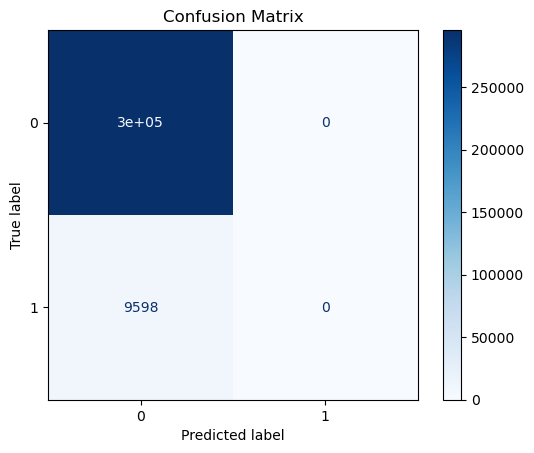

CV AUC scores: [0.824351868423195, 0.830008988645895, 0.824351868423195, 0.830008988645895, 0.7538609269196516, 0.7538609269196516]
Average CV AUC score: 0.8027405946629139


In [81]:
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Fit the model on the training set
pipeline_top15n.fit(X_train_top15n, y_train_top15n)

# Predict probabilities on the validation set
y_pred_proba_top15n = pipeline_top15n.predict_proba(X_valid_top15n)[:, 1]

# Calculate the AUC score
score = roc_auc_score(y_valid_top15n, y_pred_proba_top15n)
cv_scores.append(score)

# Predict class labels for confusion matrix
y_pred_labels_top15n = (y_pred_proba_top15n > 0.5).astype(int)  # Convert probabilities to 0 or 1 based on threshold

# Calculate the confusion matrix
cm = confusion_matrix(y_valid_top15n, y_pred_labels_top15n)

# Print confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Output the cross-validation AUC scores
print("CV AUC scores:", cv_scores)
print("Average CV AUC score:", np.mean(cv_scores))

# Additional metrics for logistic regression with binning, if relevant
# CV AUC scores: [0.8242125181967659, 0.829957314583956, 0.7533104491699891]
# Average CV AUC score: 0.8024934273169038


add alternative data source

In [ ]:
#alternative data call back
df_train_cats # all alternative columns
cat_cols # all alternative names

top 10 value
                            feature  mi_score
13             lastrejectreason_759M  0.003184
15                       lastst_736L  0.002471
10             lastcancelreason_561M  0.002391
39                  last_status_219L  0.002356
14   lastrejectreasonclient_4145040M  0.002326
25        last_cancelreason_3545846M  0.002199
28            last_rejectreason_755M  0.002184
29  last_rejectreasonclient_4145042M  0.002049
75              max_incometype_1044T  0.001189
34                   max_status_219L  0.001121

In [222]:
valued_cat_cols = [
    "lastrejectreason_759M",
    "lastst_736L",
    "lastcancelreason_561M",
    "last_status_219L",
    "lastrejectreasonclient_4145040M",
    "last_cancelreason_3545846M",
    "last_rejectreason_755M",
    "last_rejectreasonclient_4145042M",
    "max_incometype_1044T",
    "max_status_219L"
]

In [ ]:
from sklearn.feature_selection import mutual_info_classif
encoded_data = df_train_cats.apply(lambda x: pd.factorize(x)[0])
# 计算特征和目标之间的信息增益
mi_scores = mutual_info_classif(encoded_data, y, discrete_features=True)

# 将信息增益得分与特征名称相结合
mi_scores_df = pd.DataFrame({
    'feature': cat_cols,
    'mi_score': mi_scores
}).sort_values(by='mi_score', ascending=False)

print(mi_scores_df.head(10))


                             feature  mi_score
13             lastrejectreason_759M  0.003184
15                       lastst_736L  0.002471
10             lastcancelreason_561M  0.002391
39                  last_status_219L  0.002356
14   lastrejectreasonclient_4145040M  0.002326
25        last_cancelreason_3545846M  0.002199
28            last_rejectreason_755M  0.002184
29  last_rejectreasonclient_4145042M  0.002049
75              max_incometype_1044T  0.001189
34                   max_status_219L  0.001121


In [223]:
merged_ft_cat_n_nums = pd.concat([df_train_cats[valued_cat_cols], df_train_nums_after_select_top15], axis=1)

In [ ]:
preprocessor_ft_cat_n_nums = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, feature_select),  # 应用于数值型特征
        ('cat', OneHotEncoder(handle_unknown='ignore'), valued_cat_cols)  # 应用于类别型特征
    ])
pipeline_ft_cat_n_nums = Pipeline(steps=[
    ('preprocessor', preprocessor_ft_cat_n_nums),
    ('classifier', LogisticRegression(**logistic_params))
])

In [ ]:
for idx_train, idx_valid in cv.split(df_train, y):#   Because it takes a long time to divide the data set, 
    X_train_ft_cat_n_nums, y_train_ft_cat_n_nums = merged_ft_cat_n_nums.iloc[idx_train], y.iloc[idx_train]# each time the data set is divided, two models are trained to each other twice, which saves time.
    X_valid_ft_cat_n_nums, y_valid_ft_cat_n_nums = merged_ft_cat_n_nums.iloc[idx_valid], y.iloc[idx_valid]

In [239]:
pipeline_ft_cat_n_nums.fit(X_train_ft_cat_n_nums, y_train_ft_cat_n_nums)
y_pred_ft_cat_n_nums = pipeline_ft_cat_n_nums.predict_proba(X_valid_ft_cat_n_nums)[:, 1]
score = roc_auc_score(y_valid_ft_cat_n_nums, y_pred_ft_cat_n_nums)
cv_scores.append(score)

# 输出交叉验证的AUC分数
print("CV AUC scores:", cv_scores)
print("Average CV AUC score:", np.mean(cv_scores))
# 15（14）+10 nums+cats ->logistic regression model
#CV AUC scores: [0.8242125181967659, 0.829957314583956, 0.7533104491699891, 0.7639149986532734]
#Average CV AUC score: 0.7928488201509962


CV AUC scores: [0.8242125181967659, 0.829957314583956, 0.7533104491699891, 0.7639149986532734]
Average CV AUC score: 0.7928488201509962


交叉验证+混淆矩阵